In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

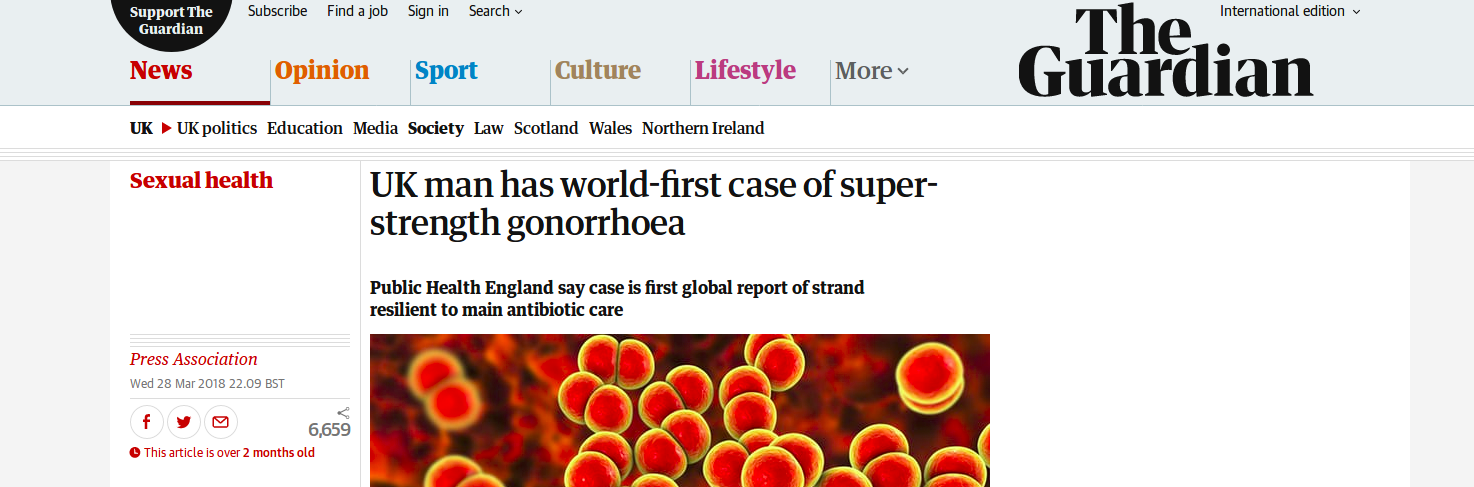

In [2]:
Image(filename= "headline.png")

# Introduction

* Antimicrobial resistance is becoming a worldwide problem

* Many pathogens are becoming resistant for many different types of antibiotics

* The institute of advanced studies (IAS) is doing research to the spreading of gonorrhoea in Amsterdam

* For gonorrhoeae there might be a new antibiotic available within years

* It is thus important to find a suitable management plan to prevent new resistance

# Mathematical model 

* Aim of our research was to build a network model to model the disease spreading
* Our network models are based on an existing mathematical model by Fingerhurth et al. (2006) [1]
    * Simple network model
    * Stochastic network

# Why use a network model?

* Sexual network portrays the sexual inter-relationships within a group of people and it is possible to study the spread of STIs in the context of social interactions [2]
* ODEs, in contrast, fail to capture the complexity of connections between cases
* By using a network a heterogeneous population can be introduced, which adds more detail in the properties of individuals. This can for example be useful in identifying high-risk groups.
* Adding this heterogeneity can have influence on the disease dynamics [3]
* Network properties can for example derived from data, in Amsterdam this is for example possible with GGD data 

# Mathematical model of antibiotic resistance N. gonorrhoeae spread

Below an image is shown which summarized the ODEs of [1] model in a scheme. Shown are the three different classes, susceptibles from group 

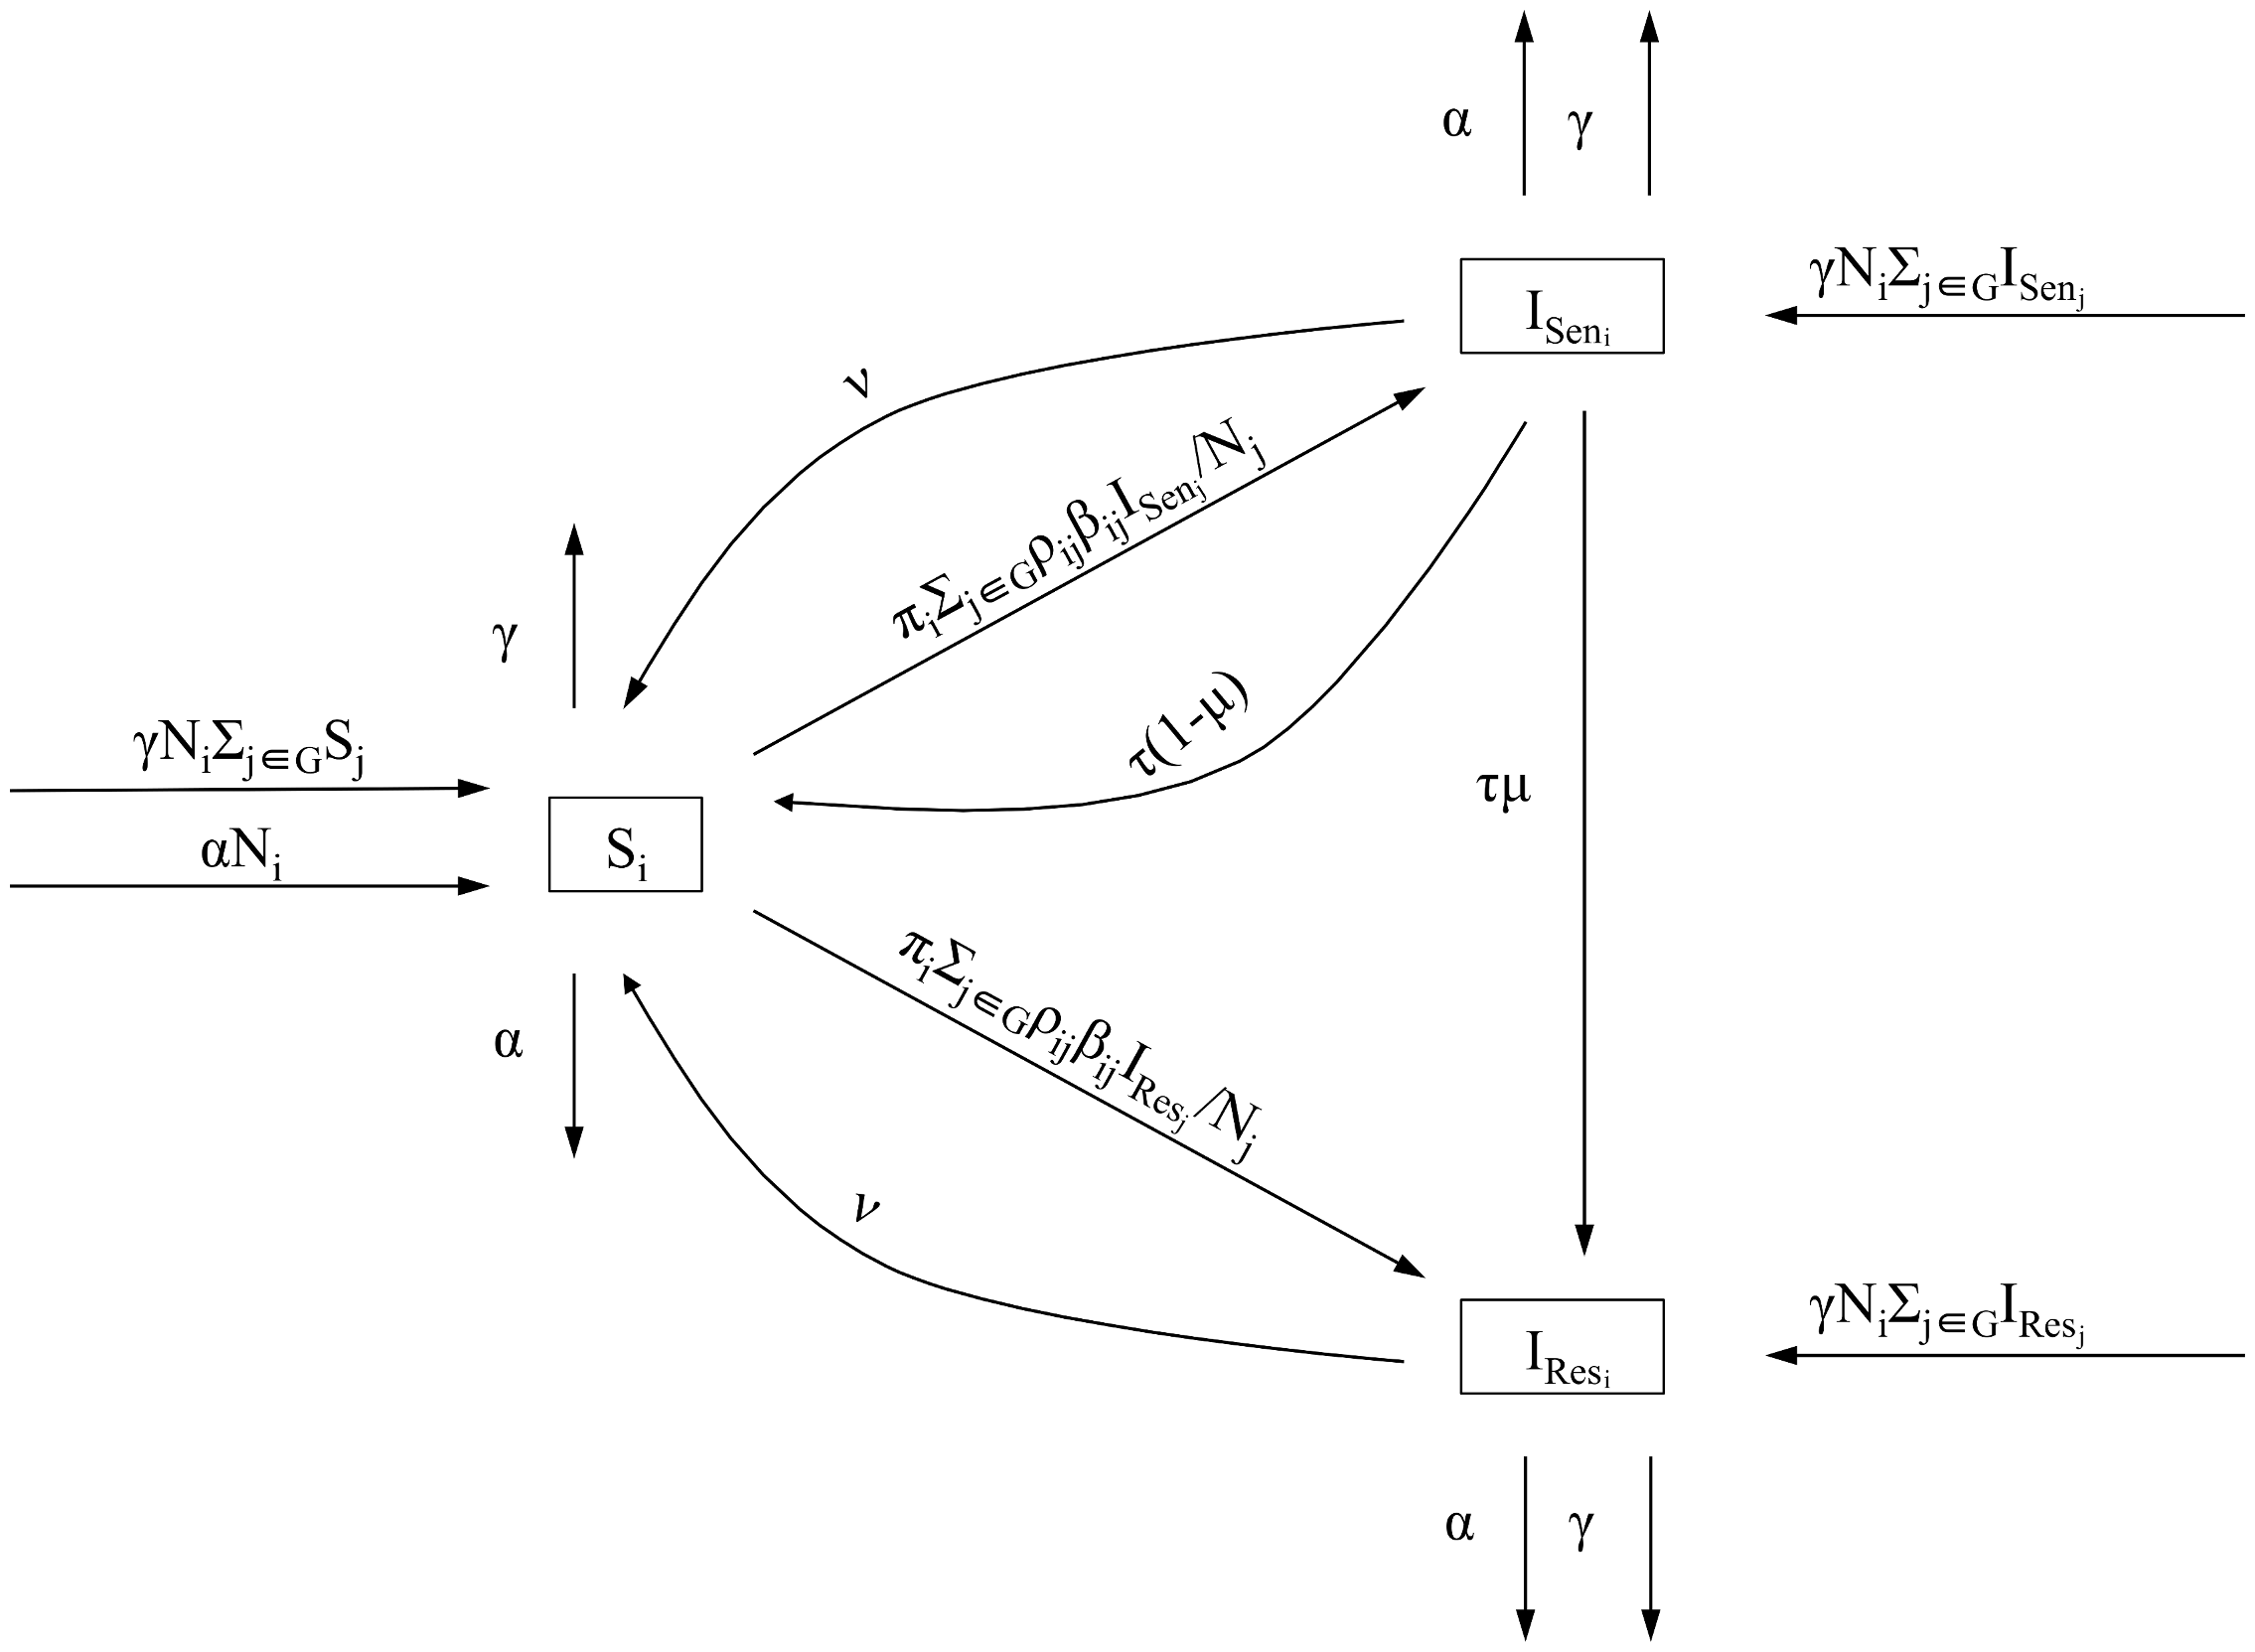

In [3]:
Image(filename= "math_model.png")

### Transmission model

Above an image is shown which summarizes the ODEs of [1] model in a scheme. The parameters in the model can be summarized as following:

* $Sen$ and $Res$ indicate the antibitotic-sensitive and -resistand N. gonorrhoeae strains
* $G = \{L,H\}$ is the set of low and high sexual activity groups, $i \in G$
* Each sexual activity group $N_i$ consists of:
    * susceptible hosts $S_i$
    * hosts infected with an antibiotic-sensitive strain, $I_{Sen_i}$
    * hosts infected with an antibiotic-resistant strain, $I_{Res_i}$
* Hosts are redistributed to either the same of the other sexual activity group at rate $\gamma$
* Hosts leave or enter the population at rate $\alpha$
* Susceptible hosts become infected depending on:
    * the partner change rate, $\pi_i$
    * the transmission probability per partnership, $\beta_{ij}$
    * the sexual mixing matrix $\rho_{ij}$ 
* Hosts infected with an antibiotic-sensitive strain can:
    * recover spontaneously at rate $\nu$
    * receive treatment at rate $\tau$
* Hosts receiving treatment recover at rate $\tau(1 - \mu)$
* Hosts develop resistance during treatment with probability $\mu$
* Host infected with an antibiotic-resistance strain can only recover spontaneously at rate $\nu$
    
The sexual mixing matrix describes how many partnerships are formed within and outside the host's activity group:

$$ \rho_{ij} = \epsilon \delta_{ij} + (1 - \epsilon) \frac{\pi_j N_j}{\sum_{k \in G} \pi_k N_k} $$

Here, $\delta_{ij} = 1$ if $i = j$ and 0 otherwise. Model parameters were estimated from sexual behavior data, calibrated trough model simulation or informed by literature. The parameters can be found on page 5 of [1].

The differential equations are solved below for two different groups: Men having sex with men (MSM) and heterosexual men (HMW).

In [4]:
## imports for the math model
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
from math_model_functions import *

## imports for the network model
import networkx as nx
from networkx.utils.random_sequence import (powerlaw_sequence)
from numba import jit
from network_model import *

## imports for the stochastic network model
from stochastic_network_model import *
import matplotlib.lines as mlines

from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='jshtml')
# import networkx.utils.create_degree_sequence as create_degree_sequence
%matplotlib notebook
# TODO: Change resolution of animation
#fix for TqdmSynchronisationWarning: Set changed size during iteration
tqdm.monitor_interval = 0

### MSM Parameters
Parameters for the "Men having sex with men group"

In [5]:
Nh = 5.3e-2
N = np.array([1 - Nh, Nh])

S = np.array([N[0]*0.995,N[1]*0.90])
Ires = np.array([0, 0])
Isen = np.array([N[0]*0.005, N[1]*0.1])

pi = np.array([0.41, 30.49])


BLL = np.array([0.42,0.59,0.77])
BHH = np.array([0.25,0.30,0.40])
alpha = 1 / 29


gamma = 1
epsilon = np.array([0.30,0.57,0.80])
phi = np.array([0.48,0.64,0.81])
mu = 1e-3
D = np.array([0.14,0.19,0.25])

y0 = np.concatenate((S, Ires, Isen))
# y0 /= np.sum(y0)
t = np.arange(0,30,0.001)
sol_msm = []
for i in range(3):
    beta = np.array([[BLL[i], 1], [1, BHH[i]]])
    beta[0, 1] = beta[1, 0] = np.sqrt(beta[0, 0] * beta[1, 1])
    sol_msm.append(odeint(math_model, y0, t, args=(N, pi, alpha, beta, gamma, epsilon[i], phi[i], mu, D[i])))
    
sol_msm = np.array(sol_msm)

In [6]:
# calculate R0 for low and high activity groups
R0_low = BLL[1] * pi[0] * D[1]
R0_high = BHH[1] * pi[1] * D[1]

# average R0 over population
R0 = Nh * R0_high + (1 - Nh) * R0_low
print(R0_low, R0_high)

0.045960999999999995 1.7379299999999998


### HMW Parameters
Parameters for the heterosexual men

In [7]:
Nh = 6.3e-2
N = np.array([1 - Nh, Nh])

S = np.array([N[0]*0.995,N[1]*0.90])
Ires = np.array([0, 0])
Isen = np.array([N[0]*0.005, N[1]*0.1])

pi = np.array([0.25, 4.57])


alpha = 1 / 29
BLL = np.array([0.79,0.87,0.94])
BHH = np.array([0.63,0.72,0.81])

gamma = 1
epsilon = np.array([0.53,0.73,0.89])
phi = np.array([0.36,0.50,0.66])
mu = 1e-3
D = np.array([0.46,0.55,0.66])

y0 = np.concatenate((S, Ires, Isen))
# y0 /= np.sum(y0)
t = np.arange(0,30,0.001)
sol_hmw = []
for i in range(3):
    beta = np.array([[BLL[i], 1], [1, BHH[i]]])
    beta[0, 1] = beta[1, 0] = np.sqrt(beta[0, 0] * beta[1, 1])
    sol_hmw.append(odeint(math_model, y0, t, args=(N, pi, alpha, beta, gamma, epsilon[i], phi[i], mu, D[i])))
    
sol_hmw = np.array(sol_hmw)

In [8]:
# calculate R0 for low and high activity groups
R0_low = BLL[1] * pi[0] * D[1]
R0_high = BHH[1] * pi[1] * D[1]

# average R0 over population
R0 = Nh * R0_high + (1 - Nh) * R0_low
print(R0_low, R0_high)

0.11962500000000001 1.8097200000000002


### Figures and plots

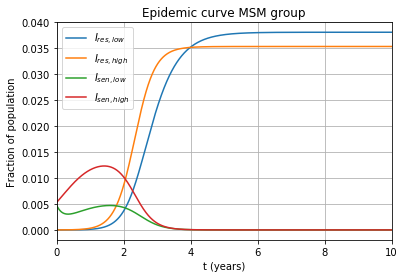

In [9]:
plt.figure()
# plt.plot(t, sol_msm[1,:, 0], label='$S_{low}$')
# plt.plot(t, sol_msm[1,:, 1], label='$S_{high}$')
plt.plot(t, sol_msm[1,:, 2], label='$I_{res, low}$')
plt.plot(t, sol_msm[1,:, 3], label='$I_{res, high}$')
plt.plot(t, sol_msm[1,:, 4], label='$I_{sen, low}$')
plt.plot(t, sol_msm[1,:, 5], label='$I_{sen, high}$')

plt.legend(loc='best')
plt.xlabel('t (years)')
plt.title("Epidemic curve MSM group")
plt.ylabel("Fraction of population")
# plt.ylim(0, 1)
plt.xlim(0, 10)
plt.grid()
plt.show()

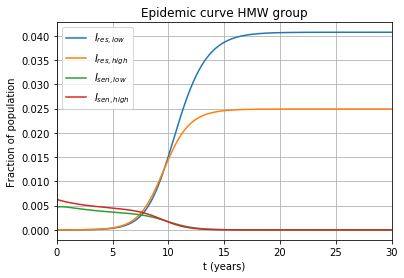

In [10]:
plt.figure()
# plt.plot(t, sol_msm[1,:, 0], label='$S_{low}$')
# plt.plot(t, sol_msm[1,:, 1], label='$S_{high}$')
plt.plot(t, sol_hmw[1,:, 2], label='$I_{res, low}$')
plt.plot(t, sol_hmw[1,:, 3], label='$I_{res, high}$')
plt.plot(t, sol_hmw[1,:, 4], label='$I_{sen, low}$')
plt.plot(t, sol_hmw[1,:, 5], label='$I_{sen, high}$')

plt.legend(loc='best')
plt.xlabel('t (years)')
plt.title("Epidemic curve HMW group")
plt.ylabel("Fraction of population")
# plt.ylim(0, 1)
plt.xlim(0, 30)
plt.grid()
plt.show()

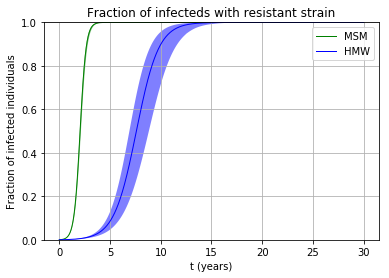

In [11]:
plt.figure()
ratio_sol_msm = (sol_msm[:,:, 2] + sol_msm[:,:, 3])/(sol_msm[:,:, 2] + sol_msm[:,:, 3] + sol_msm[:,:, 4] + sol_msm[:,:, 5])
plt.plot(t, ratio_sol_msm[1,:], label = "MSM", c = "g",linewidth=1)
plt.fill_between(t,ratio_sol_msm[0,:], ratio_sol_msm[2,:], alpha=0.5, facecolor = "g")
ratio_sol_hmw = (sol_hmw[:,:, 2] + sol_hmw[:,:, 3])/(sol_hmw[:,:, 2] + sol_hmw[:,:, 3] + sol_hmw[:,:, 4] + sol_hmw[:,:, 5])
plt.plot(t, ratio_sol_hmw[1,:], label = "HMW", c = "b",linewidth=1)
plt.fill_between(t,ratio_sol_hmw[0,:], ratio_sol_hmw[2,:], alpha=0.5, facecolor = "b")
plt.legend(loc='best')

plt.xlabel('t (years)')
plt.ylabel("Fraction of infected individuals")
plt.title("Fraction of infecteds with resistant strain")
plt.grid()
plt.ylim(0,1)
plt.show()

# Simple Contact network

- We used a simplified version of the rules in the mathematical model
- The network is a random erdos renyi network with 500 nodes and an average degree of 10

The parameters in this model are:
- Spontaneous recovery rate $\nu$
- Treatment rate $\tau$
- Hosts develop resistance during treatment with probability $\mu$
- Transmision probability $\beta$

# Model

- The values for $\tau$ , $\nu$ and $\mu$ are from the mathematical model.
- $\beta$ < K > (1 - p_inf) = 1

At each timestep each infected node can do the following:
- It recovers spontaneously
- It recovers by threatment if not resistant
- It can infect each neighbours 

## Build a network

In [12]:
# # create power law graph
# exp = 2.4
# seed = 123456789
# num = 1000
# graph = power_law_graph(exp, num, seed)

# or, create random network
degree = 10
num = 500
p = degree/num
seed = 1234
graph = random_network(p, num, seed)

# compute average degree
degrees = dict(graph.degree())
sum_of_edges = sum(degrees.values())
average_deg = sum_of_edges / len(degrees)
print(average_deg)

# compute r0 (TODO)

9.752


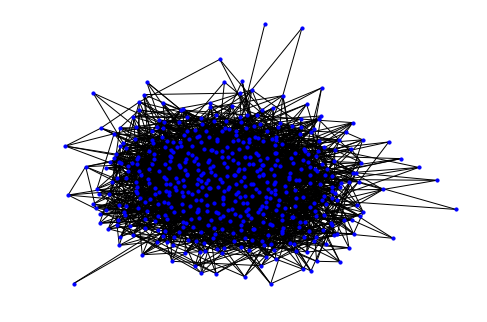

In [13]:
plt.figure()
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_color='b', node_size=10, with_labels=False)
plt.show()

## Implementation of disease spreading

In [18]:
# set person class to each node
for i in range(len(graph)):
    graph.node[i]["Data"] = Individual(i)

# create set of infecteds, initialize with 10 infecteds
init = np.random.choice(len(graph), 10, replace=False)

# time steps
t = 0
t_tot = 20
time_step = 365
dt = 1 / (time_step)

# constants of model
D = np.array([0.19,0.55]) * time_step
mu = 1e-3
PHI = [0.65, 0.50]
BETA = [0.59, 0.87]

# keep track of infecteds and steps
num_steps = int(t_tot / dt)
num_infected = np.zeros((2, num_steps))
num_res = np.zeros((2, num_steps))


p_inf = 0.8
# iterate over sextypes (MSM and HMW)
for sextype in range(2):
    phi = PHI[sextype]
    beta = BETA[sextype]
    nu = (1 - phi)/D[sextype]
    tau = phi/D[sextype]
    beta = 1-(1-1/(average_deg*(1-p_inf)))**(nu)
    num_res[sextype,:], num_infected[sextype,:], graph = network_model(beta, tau, nu, mu, init, num_steps, copy.deepcopy(graph), True)

100%|█████████████████████████████████████████████████████████████████████████████| 7300/7300 [00:35<00:00, 205.35it/s]


## The dynamics of the model

Mean number of infecteds: 349.70404109589043


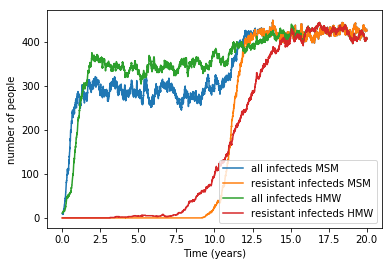

In [19]:
# plot number of infecteds
t = np.linspace(0,t_tot, num_steps)    
plt.figure()
print("Mean number of infecteds:", np.mean(num_infected))
plt.plot(t, num_infected[0,:], label='all infecteds MSM')
plt.plot(t, num_res[0,:], label='resistant infecteds MSM')
plt.plot(t, num_infected[1,:], label='all infecteds HMW')
plt.xlabel("Time (years)")
plt.ylabel("number of people")
plt.plot(t, num_res[1,:], label='resistant infecteds HMW')
plt.legend()
plt.show()


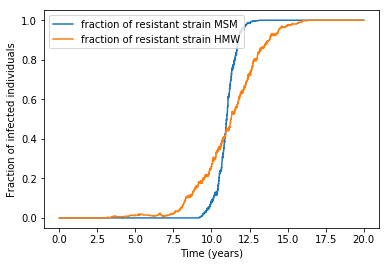

In [20]:
plt.figure()
plt.plot(t,num_res[0,:]/num_infected[0,:], label='fraction of resistant strain MSM')
plt.plot(t,num_res[1,:]/num_infected[1,:], label='fraction of resistant strain HMW')
# plt.plot(num_res)
plt.xlabel("Time (years)")
plt.ylabel("Fraction of infected individuals")
plt.legend()
plt.show()

## Animation

In [21]:
# set person class to each node
for i in range(len(graph)):
    graph.node[i]["Data"] = Individual(i)

# create set of infecteds, initialize with 10 infecteds
init = np.random.choice(len(graph), 10, replace=False)

# time
t = 0
t_tot = 5
time_step = 365
dt = 1 / (time_step)

# constants of model
D = np.array([0.19,0.55]) * time_step
mu = 1e-3
PHI = [0.65, 0.50]
BETA = [0.59, 0.87]

# choose MSM or HMW to model
sextype = 0
phi = PHI[sextype]
beta = BETA[sextype]
nu = (1 - phi)/D[sextype]
tau = phi/D[sextype]
beta = 1-(1-1/(average_deg*(1-p_inf)))**(nu)

# initial state
_, _, graph = network_model(beta, tau, nu, mu, init, 0, graph, doInit=True, disable_progress=True)

# get values of disease status
values = []
for j in range(len(graph.nodes())):
    if graph.node[j]["Data"].disease_status == 0:
        values.append("Black")
    elif graph.node[j]["Data"].disease_status == 1:
        values.append("Blue")
    elif graph.node[j]["Data"].disease_status == 2:
        values.append("Red")
        
# create figure and set axes
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
im1, = ax2.plot([], [], c = 'b', label='all infecteds MSM')
im2, = ax2.plot([], [], c = 'r', label='resistant infecteds MSM')
ax2.legend()
ax2.set_xlim(0,t_tot)
ax2.set_ylim(0,num)

# initialize
pos = nx.spring_layout(graph) 
plt.close()
ani_step = 365//5
frames = (t_tot*365)//ani_step
num_infected = np.zeros(ani_step*frames)
num_res = np.zeros(ani_step*frames)

# update function for animation
def update(i):
    if i<1:
        temp_res, temp_infected, _ = network_model(beta, tau, nu, mu, init, 1, graph, doInit=False, disable_progress=True)
    else:
        temp_res, temp_infected, _ = network_model(beta, tau, nu, mu, init, ani_step, graph, doInit=False, disable_progress=True)
    num_infected[i*ani_step:(i+1)*ani_step] = temp_infected
    num_res[i*ani_step:(i+1)*ani_step] = temp_res
    t = np.linspace(0,i*ani_step/365, i*ani_step) 
    im1.set_data(t, num_infected[:i*ani_step])
    im2.set_data(t, num_res[:i*ani_step])
    ax1.clear()
    
    # solution at step i
    values = []
    for j in range(len(graph.nodes())):
        if graph.node[j]["Data"].disease_status == 0:
            values.append("Black")
        elif graph.node[j]["Data"].disease_status == 1:
            values.append("Blue")
        elif graph.node[j]["Data"].disease_status == 2:
            values.append("Red")
    nx.draw(graph, pos=pos, node_color=values, node_size=10, ax=ax1, clim = 2)
    
    # Scale plot ax
    ax1.set_title("Frame %d:    "%(i+1), fontweight="bold")
    ax1.set_xticks([])
    ax1.set_yticks([])
    
# animate!
anim = animation.FuncAnimation(fig, update, frames=frames, interval=100, repeat=True)

In [22]:
anim

# Improvements

- with lower beta the sensitive population dies out too quickly
- other types of networks that better models reality

# Stochastic network model 

The stochastic network model is based on an existing model by Kretzschmar, M. et al. (1996) [4]

The system consists of Persons defined by:
- Gender (male / female)
- Age (15 - 64)
- Sexual activity (high / low)
- Disease status (uninfected or (non-)resistant (a)symptomatic)

During each timestep, Partnerships are formed between two Persons. A Partnership is defined by:
- Type (casual or steady)
- The two Persons involved

The sexual contact network is therefore dynamic in time

Each timestep of the model consists of seven parts:
<ol>
    <li>Partnership formation</li>
    <li>Disease transmission</li>
    <li>Separation of partnerships</li>
    <li>Replacement</li>
    <li>Recovery</li>
    <li>Treatment</li>
    <li>Advance time</li>
</ol>

## Initialize model

<ol>
    <li>Initialize 10,000 Persons of random age. 5% of Persons with age < 35 have high sexual activity</li>
    <li>Perform 2,000 iterations to obtain the steady state</li>
    <li>Infect 10% of the core group (high sexual activity) with non-resistant asymptomatic disease</li>
</ol>

The resistant disease enters the system through treatment; treatment will result in contracting the resistant disease with probability 0.01%

In [23]:
#initialize System
s = System()
s.set_constants()
s.initialize()

#initialize lists to store counts
singles_list = []
steady_list = []
partnerships_list = []

#start time steps to reach steady state
start = time.time()
for i in range(2000):
    s.time_step()
    singles_list.append(s.number_of_singles)
    steady_list.append(s.number_of_steady)
    partnerships_list.append(len(s.partnerships))

print("TIME TO INITIALIZE MODEL: %.2f"%(time.time() - start))

#print core size (sexual_activity == 1)
core_size = len(s.high_sexual_activity)
print("Core size: %d"%(core_size))

#random infection of the core group
infect = np.random.choice(list(s.high_sexual_activity),int(0.1 * core_size))
for i in infect:
    p = s.persons[i]
    p.asymptomatic_infection(s)

#set System time to zero
s.time = 0

TIME TO INITIALIZE MODEL: 33.30
Core size: 201


### Time-evolution towards the steady state

In [24]:
# #print percentage of singles in the System
# singles = len(s.singles)/len(s.persons) * 100
# print("Percentage of singles: %f"%(singles))

# #print percentage having one partner
# one_partner = 0
# for p in s.persons:
#     if len(p.current_partners) == 1:
#         one_partner += 1
# one = one_partner/len(s.persons) * 100
# print("Percentage having one partner: %f"%(one))
# print("Percentage having more than one partner: %f"%(100 - singles - one))

In [25]:
%%capture
#plot change over time, reaching the steady state
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(singles_list,label="number of singles")
ax.plot(steady_list,label="number of steady partnerships")
ax.plot(partnerships_list,label="number of partnerships")
ax.plot(len(s.persons)-np.array(singles_list),label="number of persons in a partnership")
ax.plot(np.array(partnerships_list) - np.array(steady_list),label="number of casual partnerships")
ax.set_title("Time-evolution of Persons and Partnerships during initialization")
ax.set_xlabel("Days")
ax.set_ylabel("Counts")
ax.legend();

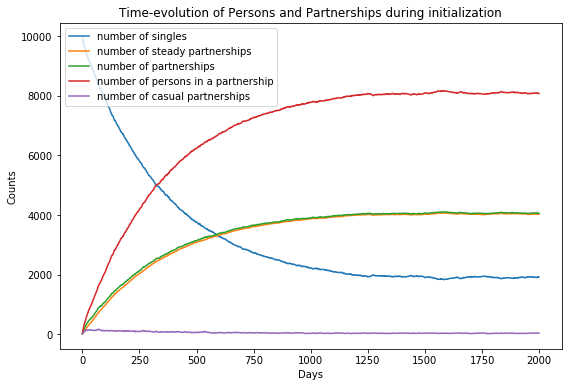

In [26]:
fig

### Evolve system over time

In [27]:
#initialize lists
singles_list = [s.number_of_singles]
steady_list = [s.number_of_steady]
partnerships_list = [len(s.partnerships)]
symptomatic_list = [s.number_of_symptomatic]
asymptomatic_list = [s.number_of_asymptomatic]
res_symp_list = [s.number_of_res_symp]
res_asymp_list = [s.number_of_res_asymp]

#store starting time
start = time.time()

for i in range(12000):
    #make a single time step
    s.time_step()
    
    #append new values to lists
    singles_list.append(s.number_of_singles)
    steady_list.append(s.number_of_steady)
    partnerships_list.append(len(s.partnerships))
    symptomatic_list.append(s.number_of_symptomatic)
    asymptomatic_list.append(s.number_of_asymptomatic)
    res_symp_list.append(s.number_of_res_symp)
    res_asymp_list.append(s.number_of_res_asymp)

#print evaluation time
print(time.time() - start)

193.6872284412384


### Time-evolution of the population

In [28]:
%%capture
#show change in counts over time
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(singles_list,label="number of singles")
ax.plot(steady_list,label="number of steady partnerships")
ax.plot(partnerships_list,label="number of partnerships")
ax.plot(len(s.persons)-np.array(singles_list),label="number of persons in a partnership")
ax.plot(np.array(partnerships_list) - np.array(steady_list),label="number of casual partnerships")
ax.set_title("Evolution of the system over time")
ax.set_xlabel("Time in days")
ax.set_ylabel("Counts")
ax.legend();

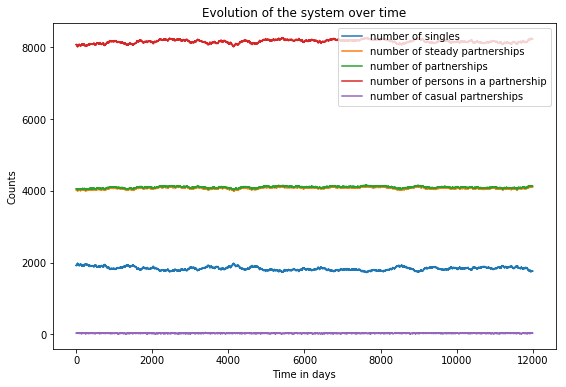

In [29]:
fig

### Time-evolution of infecteds over time

In [30]:
%%capture
#show change in infecteds over time
fig,ax = plt.subplots(figsize=(9,6))
ax.plot(symptomatic_list,label="symptomatically infected")
ax.plot(asymptomatic_list,label="asymptomatically infected")
ax.plot(res_symp_list,label="resistant symptomatically infected")
ax.plot(res_asymp_list,label="resistant asymptomatically infected")
ax.set_title("Evolution of infecteds over time")
ax.set_xlabel("Time in days")
ax.set_ylabel("Counts")
ax.legend();

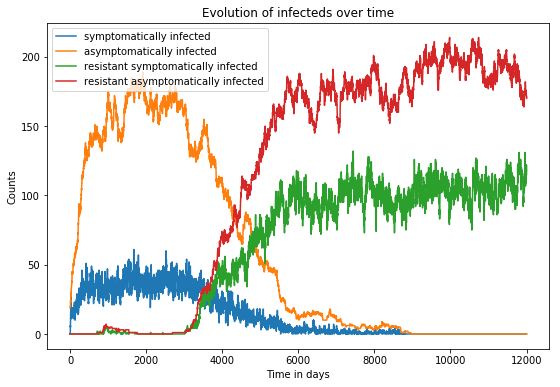

In [31]:
fig

### Fraction of resistant infecteds over all infecteds over time

In [32]:
%%capture
#show change in resistant infections over time
res_inf = np.array(res_symp_list) + np.array(res_asymp_list)
inf = res_inf + np.array(symptomatic_list) + np.array(asymptomatic_list)
fig,ax = plt.subplots(figsize=(9,6))
ax.plot(res_inf/inf)
ax.set_title("Fraction of resistant infecteds over all infecteds over time")
ax.set_xlabel("Time in days")
ax.set_ylabel("Fraction of resistant infections");

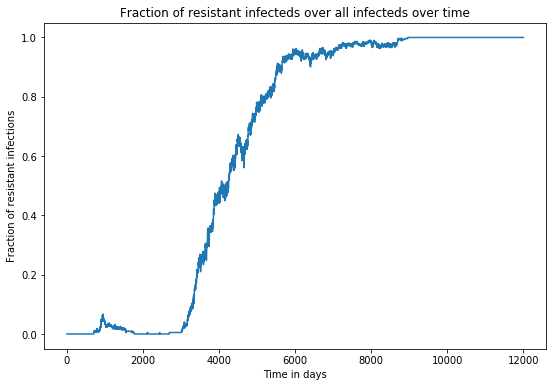

In [33]:
fig

### Infectiousness of the disease ($R_0$)

Although the disease might seem quite infectious, simulations have shown $R_0=0.90 \pm 2.93$ (N=1,000, 95% CI). The spread of the disease is very dependent on where the disease is started. If a person with high sexual activity is infected, it will quickly spread throughout the entire core group whereas a person with low sexual activity may only affect a select few different partners

### Animation

In [34]:
%%capture
#initialize System
s = System()
s.set_constants()
s.initialize()

#evolve to steady state
for i in range(2000):
    s.time_step()
    
#random infection of the core group
core_size = len(s.high_sexual_activity)
infect = np.random.choice(list(s.high_sexual_activity),int(0.1 * core_size))
for i in infect:
    p = s.persons[i]
    p.asymptomatic_infection(s)

#dictionary mapping disease_status to a color
color_dict = {0:'black',1:'blue',2:'green',3:'red',4:'orange'}
dis_dict = {0:'Uninfected',1:'Non-resistant symptomatic',
            2:'Non-resistant asymptomatic',3:'Resistant symptomatic',
            4:'Resistant asymptomatic'}

def plot_graph(i):
    """
    Draw graph for a single time step
    """
    global s, pos, ax
    
    if i > 0:
        for j in range(365):
            s.time_step()
    
    persons = set()
    edges_list = []
    for identifier in s.high_sexual_activity:
        p = s.persons[identifier]
        for partner in p.current_partners:
            persons.add(partner)
            persons.add(identifier)
            edges_list.append((identifier,partner))
    persons_list = sorted(list(persons))

    sizes = []
    disease = []
    for identifier in persons_list:
        disease.append(color_dict[s.persons[identifier].disease_status])
        sizes.append(15+30*s.persons[identifier].sexual_activity)

    ax.clear()
    G = nx.Graph()
    G.add_nodes_from(persons_list)
    G.add_edges_from(edges_list)
    nx.draw(G,node_color=disease,node_size=sizes,ax=ax)
    handles = []
    for index in range(5):
        handles.append(mlines.Line2D([],[],color=color_dict[index],marker='o',linestyle='None',
                                    markersize=10,label=dis_dict[index]))
    ax.legend(handles=handles,loc='upper left')
    ax.set_title("Core group and their partners\nT = %d years"%i)

fig,ax = plt.subplots(figsize=(10,5))
anim = animation.FuncAnimation(fig,plot_graph,frames=34,interval=1000,repeat=False)

In [35]:
anim

# Determine $R_0$

In [ ]:
#import to perform in parallel
from joblib import Parallel, delayed

#Note that R0 is very high, due to treatment. If Person A is asymptomatic and has a Partnership with Person B,
#who contracts the symptomatic disease, Person B gets treatment. Person A is however still infectious, so Person
#B will almost immediately contract the disease again. To 'solve' this, we convert the list of Person identifiers
#to a set, such that infections are counted uniquely per Person.

def get_R0():
    """
    Gets a single sample of R0 from the System    
    """
    #initialize System
    s = System()
    s.set_constants(r0=True)
    s.initialize()

    #evolve to steady state
    for j in range(1000):
        s.time_step()
    
    #infect Person 0
    s.persons[0].asymptomatic_infection(s)
    
    #loop until Person 0 is cured
    while not s.persons[0].disease_status == 0:
        s.time_step()
    
    #return R0
    return s.r0_infected

#perform 4 jobs in parallel
a = Parallel(n_jobs=4,verbose=5)(delayed(get_R0)() for i in range(1000))

#convert lists to sets, such that we only have the unique Persons infected
a = [len(set(x)) for x in a]

#print R0 with 95% CI
print(a)
print("R_0 = %f +/- %f"%(np.mean(a),1.96*np.std(a)))

# Conclusions

- The system of ODE's allowed us to analyse the disease spread using two distinct groups, however it is too simplistic
- Simple network captures a more realistic discrete modelling case
- Stochastic network model is the most complex one, it includes many parameters and is closest to the real-life situation


### <font color='red'>The resistant strain manages to become fully dominant and endemic in all three models!</font>

# Future work
- Addition of MSM to this model will give a more complete representation of real-life situation
- Stochastic network model can be used to model different tactics to combat the disease spread and guide resistance management strategies
- Acquisition of more data will provide a better parameter estimation and improve model's analytic power

# References

[1] Fingerhuth, S. M., Bonhoeffer, S., Low, N., & Althaus, C. L. (2016). Antibiotic-resistant Neisseria gonorrhoeae spread faster with more treatment, not more sexual partners. PLoS pathogens, 12(5), e1005611.

[2] De, P., Singh, A. E., Wong, T., Yacoub, W., & Jolly, A. M. (2004). Sexual network analysis of a gonorrhoea outbreak. Sexually transmitted infections, 80(4), 280-285.

[3] Bansal, S., Grenfell, B. T., & Meyers, L. A. (2007). When individual behaviour matters: homogeneous and network models in epidemiology. Journal of the Royal Society Interface, 4(16), 879-891.

[4] Kretzschmar, M., van Duynhoven, Y. T., & Severijnen, A. J. (1996). Modeling prevention strategies for gonorrhea and chlamydia using stochastic network simulations. American Journal of Epidemiology, 144(3), 306-317.